# Automated Annotation

In [1]:
# First, import the necessary modules and functions
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from myst_nb import glue
from nilearn import image, plotting
from repo2data.repo2data import Repo2Data

from nimare import dataset, extract

# Install the data if running locally, or points to cached data if running on neurolibre
DATA_REQ_FILE = os.path.abspath("../binder/data_requirement.json")
repo2data = Repo2Data(DATA_REQ_FILE)
data_path = repo2data.install()
data_path = os.path.join(data_path[0], "data")

---- repo2data starting ----
/Users/taylor/Documents/nbc/nimare-paper/conda_env/lib/python3.8/site-packages/repo2data
Config from file :
/Users/taylor/Documents/nbc/nimare-paper/binder/data_requirement.json
Destination:
./../data/nimare-paper

Info : ./../data/nimare-paper already downloaded


As mentioned in the discussion of BrainMap ([](content:resources:brainmap)), manually annotating studies in a meta-analytic database can be a time-consuming and labor-intensive process.
To facilitate more efficient (albeit lower-quality) annotation, NiMARE supports a number of automated annotation approaches.
These include [](content:annotation:ngram), [](content:annotation:cogat), [](content:annotation:lda), and [](content:annotation:gclda).

NiMARE users may download abstracts from PubMed as long as study identifiers in the `Dataset` correspond to PubMed IDs (as in Neurosynth and NeuroQuery).
Abstracts are much more easily accessible than full article text, so most annotation methods in NiMARE rely on them.

Below, we use the function {py:func}`~nimare.extract.download_abstracts` to download abstracts for the Neurosynth `Dataset`.
This will attempt to extract metadata about each study in the `Dataset` from PubMed, and then add the abstract available on Pubmed to the `Dataset`'s `texts` attribute, under a new column names "abstract".

```{important}
{py:func}`~nimare.extract.download_abstracts` only works when there is internet access.
Since this book will often be built on nodes without internet access, we will share the code
used to download abstracts, but will actually load and use a pre-generated version of the Dataset.
```

```python
# First, load a Dataset without abstracts
neurosynth_dset_first_500 = dataset.Dataset.load(
    os.path.join(data_path, "neurosynth_dataset_first500.pkl.gz")
)

# Now, download the abstracts using your email address
neurosynth_dset_first_500 = extract.download_abstracts(
    neurosynth_dset_first_500,
    email="example@email.com",
)

# Finally, save the Dataset with abstracts to a pkl.gz file
neurosynth_dset_first_500.save(
    os.path.join(data_path, "neurosynth_dataset_first500_with_abstracts.pkl.gz"),
)
```

In [2]:
neurosynth_dset_first_500 = dataset.Dataset.load(
    os.path.join(data_path, "neurosynth_dataset_first500_with_abstracts.pkl.gz"),
)

(content:annotation:ngram)=
## N-gram term extraction

**N-gram term extraction** refers to the vectorization of text into contiguous sets of words that can be counted as individual tokens.
The upper limit on the number of words in these tokens is set by the user.

NiMARE has the function {py:func}`~nimare.annotate.text.generate_counts` to extract n-grams from text.
This method produces either term counts or term frequency- inverse document frequency (tf-idf) values for each of the studies in a `Dataset`.

In [3]:
from nimare import annotate

counts_df = annotate.text.generate_counts(
    neurosynth_dset_first_500.texts,
    text_column="abstract",
    tfidf=False,
    min_df=10,
    max_df=0.95,
)

/Users/taylor/Documents/nbc/nimare-paper/conda_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


This term count `DataFrame` will be used later, to train a GCLDA model.

(content:annotation:cogat)=
## Cognitive Atlas term extraction and hierarchical expansion

**Cognitive Atlas term extraction** leverages the structured nature of the Cognitive Atlas in order to extract counts for individual terms and their synonyms in the ontology, as well as to apply hierarchical expansion to these counts based on the relationships specified between terms.
This method produces both basic term counts and expanded term counts based on the weights applied to different relationship types present in the ontology.

First, we must use {py:func}`~nimare.extract.download_cognitive_atlas` to download the current version of the Cognitive Atlas ontology.
This includes both information about individual terms in the ontology and asserted relationships between those terms.

NiMARE will automatically attempt to extrapolate likely alternate forms of each term in the ontology, in order to make extraction easier.
For an example, see {numref}`tbl:table_cogat_forms`.

In [4]:
cogatlas = extract.download_cognitive_atlas(data_dir=data_path, overwrite=False)
id_df = pd.read_csv(cogatlas["ids"])
rel_df = pd.read_csv(cogatlas["relationships"])

cogat_counts_df, rep_text_df = annotate.cogat.extract_cogat(
    neurosynth_dset_first_500.texts, id_df, text_column="abstract"
)

INFO:nimare.extract.utils:Dataset found in ./../data/nimare-paper/data/cognitive_atlas



In [5]:
example_forms = id_df.loc[id_df["name"] == "dot motion task"][["id", "name", "alias"]]
glue("table_cogat_forms", example_forms)

,id,name,alias
803,trm_4f244ad7dcde7,dot motion task,random-dot motion task
1563,trm_4f244ad7dcde7,dot motion task,dot motion task
1589,trm_4f244ad7dcde7,dot motion task,dot-motion task
1595,trm_4f244ad7dcde7,dot motion task,moving-dot task
2039,trm_4f244ad7dcde7,dot motion task,rdm task


```{glue:figure} table_cogat_forms
:name: "tbl:table_cogat_forms"
:align: center

An example of alternate forms characterized by the Cognitive Atlas and extrapolated by NiMARE.
Certain alternate forms (i.e., synonyms) are specified within the Cognitive Atlas, while others are inferred automatically by NiMARE according to certain rules (e.g., removing parentheses).
```

In [6]:
# Define a weighting scheme.
# In this scheme, observed terms will also count toward any hypernyms (isKindOf),
# holonyms (isPartOf), and parent categories (inCategory) as well.
weights = {"isKindOf": 1, "isPartOf": 1, "inCategory": 1}
expanded_df = annotate.cogat.expand_counts(cogat_counts_df, rel_df, weights)

# Sort by total count and reduce for better visualization
series = expanded_df.sum(axis=0)
series = series.sort_values(ascending=False)
series = series[series > 0]
columns = series.index.tolist()

/Users/taylor/Documents/nbc/nimare-paper/conda_env/lib/python3.8/site-packages/nimare/annotate/cogat.py:196: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  counts_df[col] = 0
/Users/taylor/Documents/nbc/nimare-paper/conda_env/lib/python3.8/site-packages/nimare/annotate/cogat.py:196: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  counts_df[col] = 0
/Users/taylor/Documents/nbc/nimare-paper/conda_env/lib/python3.8/site-packages/nimare/annotate/cogat.py:196: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resu

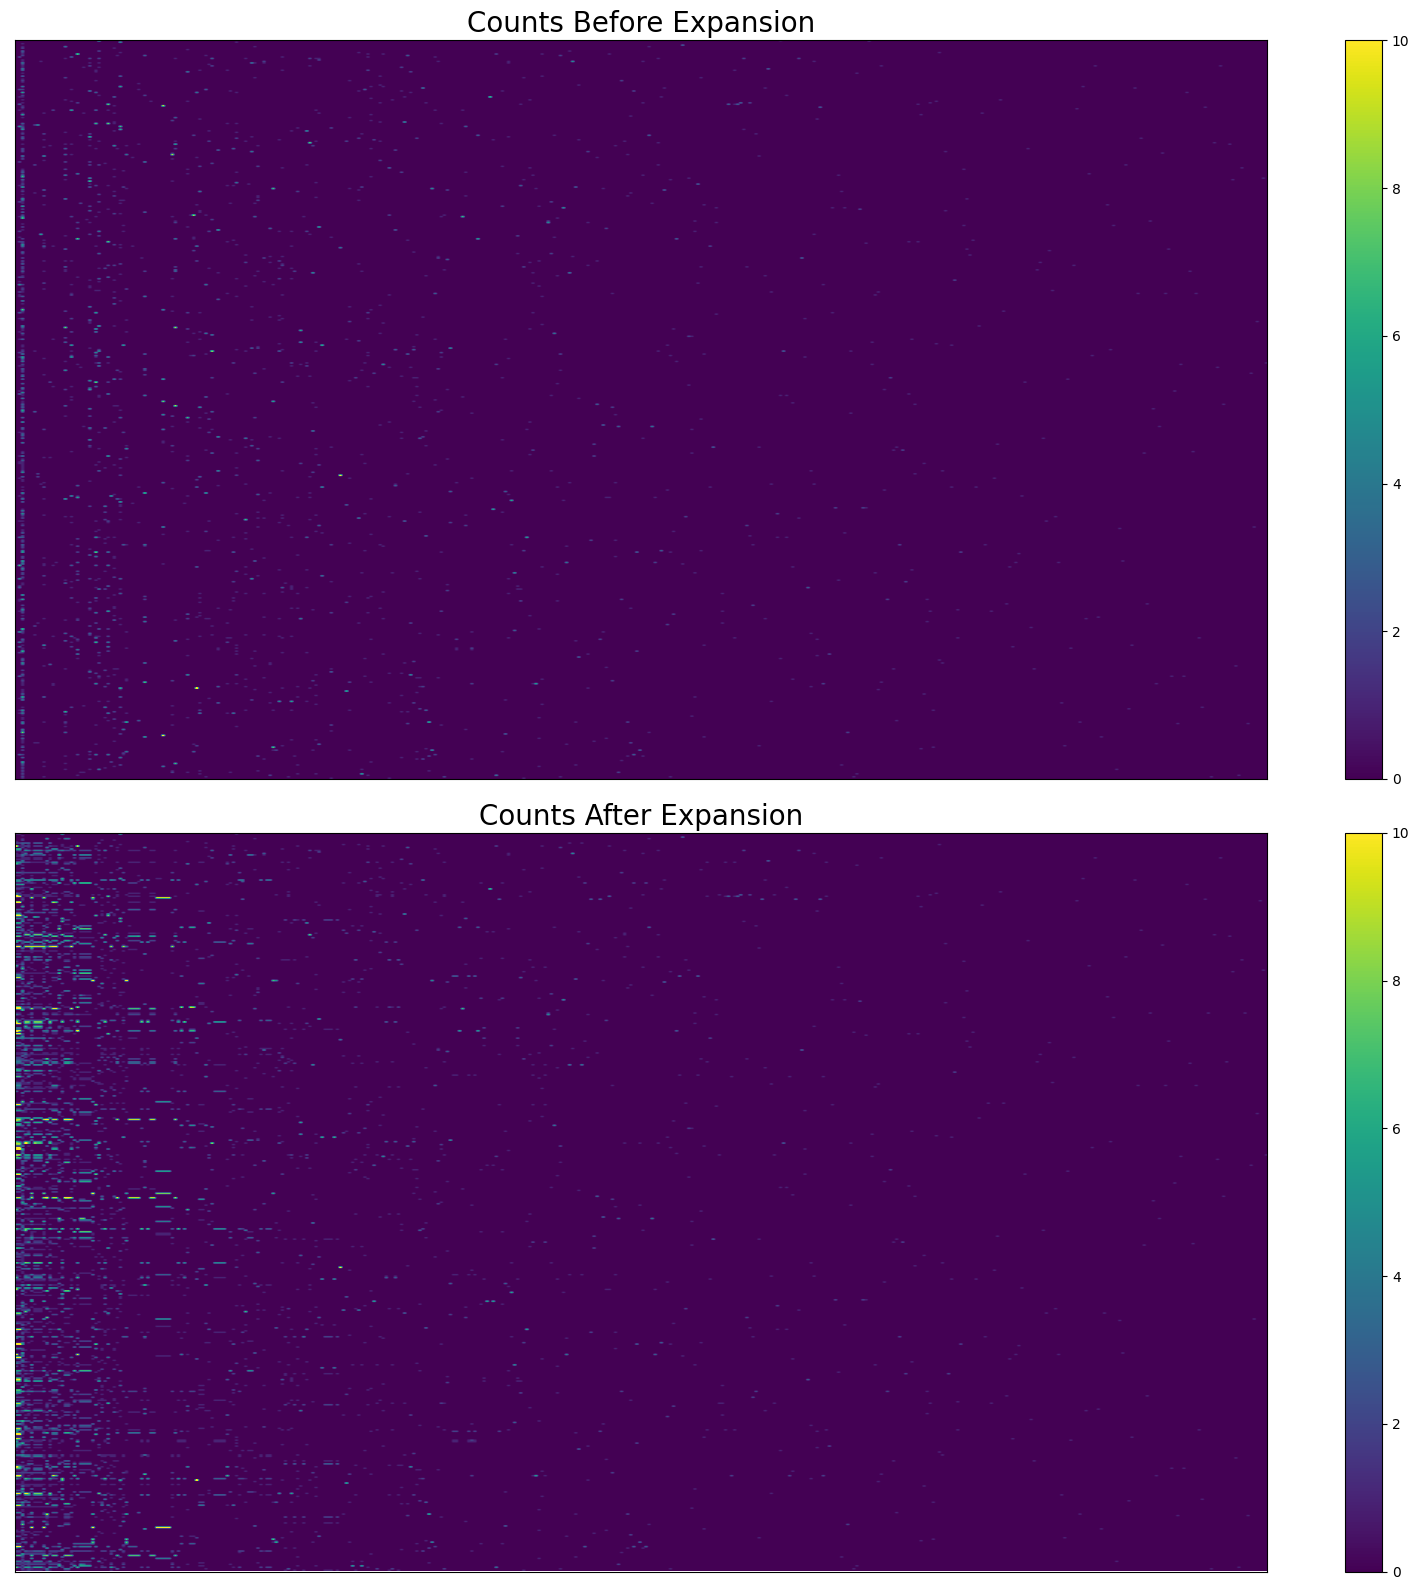

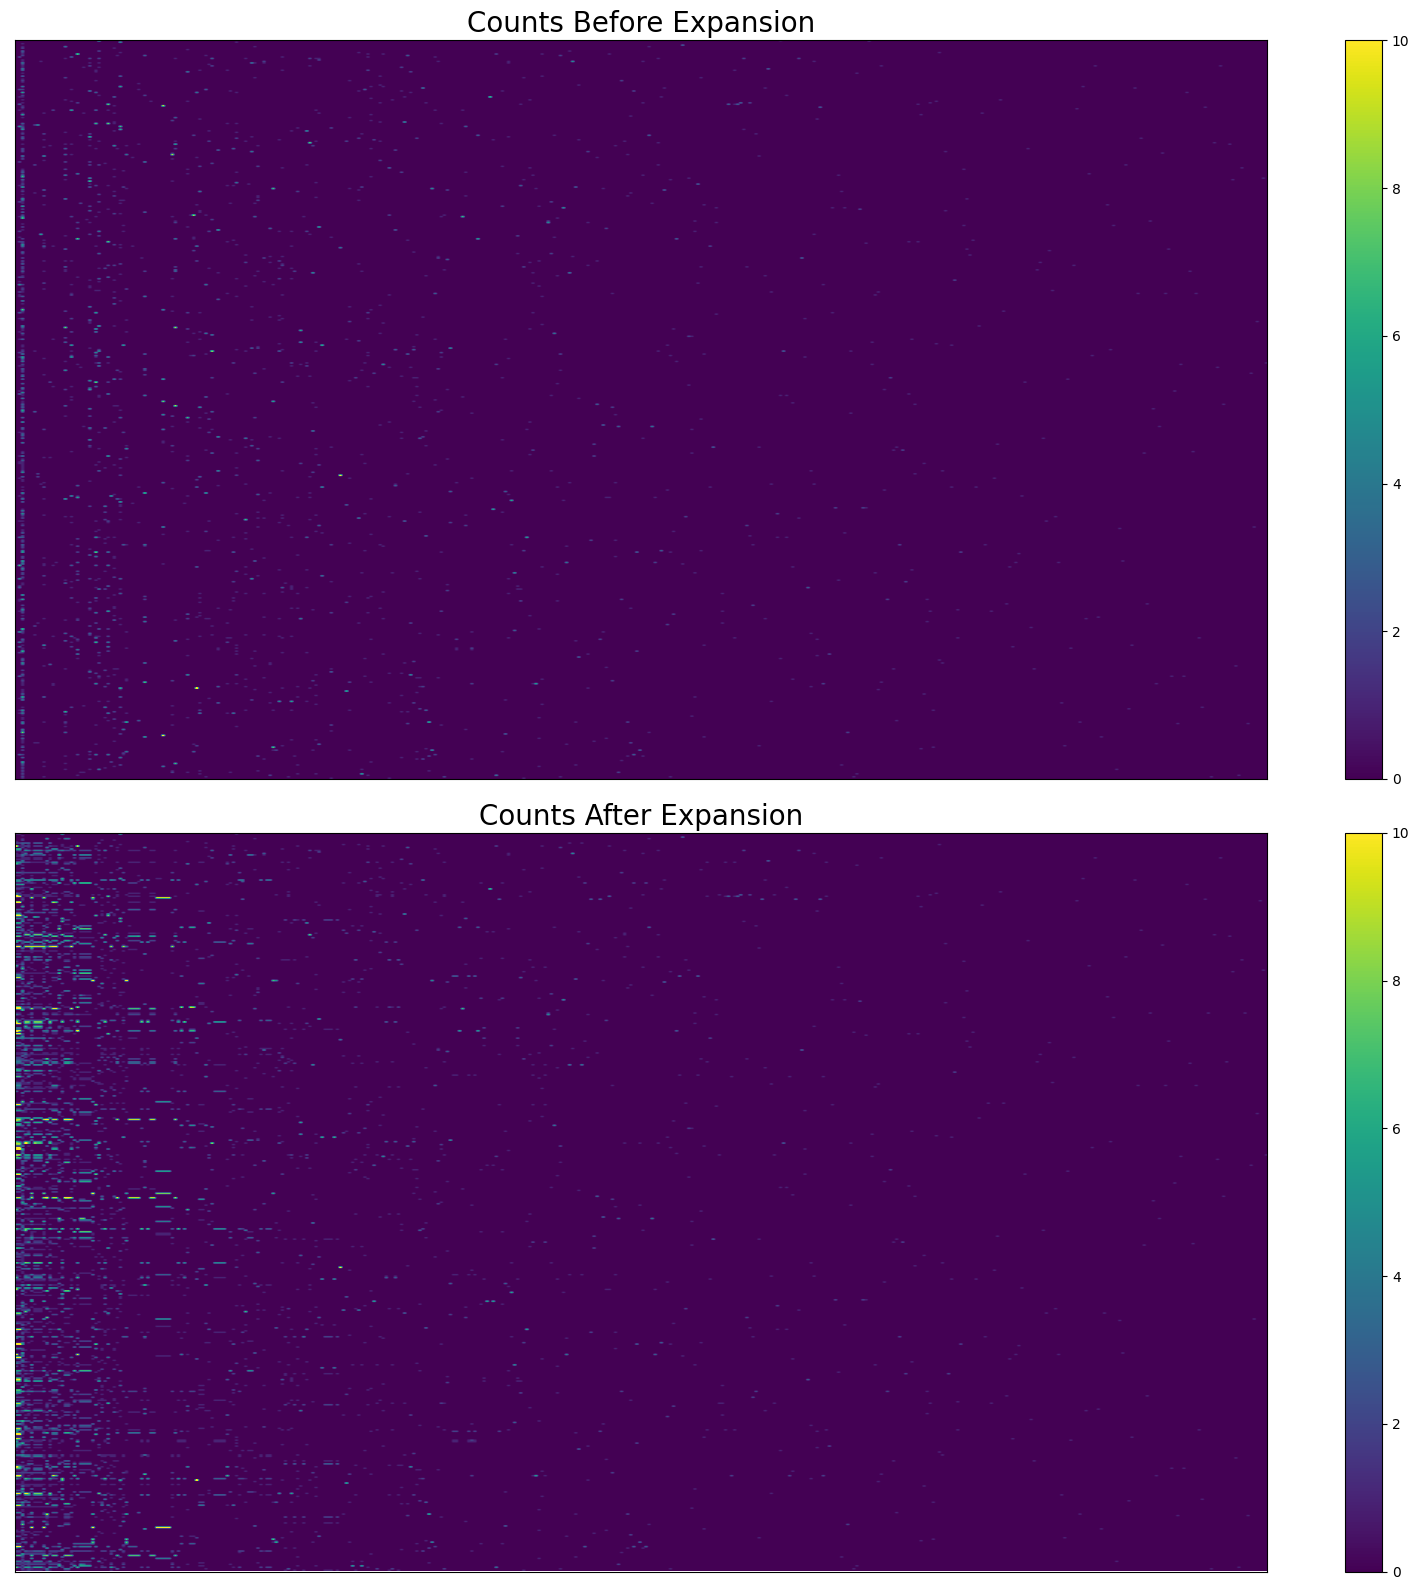

In [7]:
# Raw counts
fig, axes = plt.subplots(figsize=(16, 16), nrows=2, sharex=True)
pos = axes[0].imshow(
    cogat_counts_df[columns].values,
    aspect="auto",
    vmin=0,
    vmax=10,
)
fig.colorbar(pos, ax=axes[0])
axes[0].set_title("Counts Before Expansion", fontsize=20)
axes[0].yaxis.set_visible(False)
axes[0].xaxis.set_visible(False)
axes[0].set_ylabel("Study", fontsize=16)
axes[0].set_xlabel("Cognitive Atlas Term", fontsize=16)

# Expanded counts
pos = axes[1].imshow(
    expanded_df[columns].values,
    aspect="auto",
    vmin=0,
    vmax=10,
)
fig.colorbar(pos, ax=axes[1])
axes[1].set_title("Counts After Expansion", fontsize=20)
axes[1].yaxis.set_visible(False)
axes[1].xaxis.set_visible(False)
axes[1].set_ylabel("Study", fontsize=16)
axes[1].set_xlabel("Cognitive Atlas Term", fontsize=16)

fig.tight_layout()
glue("figure_cogat_expansion", fig, display=False)

```{glue:figure} figure_cogat_expansion
:name: "figure_cogat_expansion"
:align: center

The effect of hierarchical expansion on Cognitive Atlas term counts from abstracts in Neurosynth's first 500 papers. There are too many terms and studies to show individual labels.
```

In [8]:
# Here we delete the recent variables for the sake of reducing memory usage
del cogatlas, id_df, rel_df, cogat_counts_df, rep_text_df
del weights, expanded_df, series, columns

(content:annotation:lda)=
## Latent Dirichlet allocation

**Latent Dirichlet allocation** (LDA) {cite:p}`Blei2003-lh` was originally combined with meta-analytic neuroimaging data in {cite:t}`Poldrack2012-it`.
LDA is a generative topic model which, for a text corpus, builds probability distributions across documents and words.
In LDA, each document is considered a mixture of topics.
This works under the assumption that each document was constructed by first randomly selecting a topic based on the document's probability distribution across topics, and then randomly selecting a word from that topic based on the topic's probability distribution across words.
While this is not a useful generative model for producing documents, LDA is able to discern cohesive topics of related words.
{cite:t}`Poldrack2012-it` were able to apply LDA to full texts from neuroimaging articles in order to develop cognitive neuroscience-related topics and to run topic-wise meta-analyses.
This method produces two sets of probability distributions: (1) the probability of a word given topic and (2) the probability of a topic given article.

NiMARE's {py:class}`~nimare.annotate.lda.LDAModel` is a light wrapper around scikit-learn's LDA implementation.

Here, we train an LDA model ({py:class}`~nimare.annotate.lda.LDAModel`) on the first 500 studies of the Neurosynth `Dataset`, with 50 topics in the model.

In [9]:
from nimare import annotate

lda_model = annotate.lda.LDAModel(n_topics=50, max_iter=1000, text_column="abstract")

# Fit the model
lda_model.fit(neurosynth_dset_first_500)

/Users/taylor/Documents/nbc/nimare-paper/conda_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Dataset(500 experiments, space='mni152_2mm')

The most important products of training the `LDAModel` object is its `distributions_` attribute.
`LDAModel.distributions_` is a dictionary containing arrays and DataFrames created from training the model.
We are particularly interested in the `p_topic_g_word_df` distribution, which is a `pandas` `DataFrame` in which each row corresponds to a topic and each column corresponds to a term (n-gram) extracted from the `Dataset`'s texts.
The cells contain weights indicating the probability distribution across terms for each topic.

Additionally, the `LDAModel` updates the `Dataset`'s {py:attr}`~nimare.dataset.Dataset.annotations` attribute, by adding columns corresponding to each of the topics in the model.
Each study in the `Dataset` thus receives a weight for each topic, which can be used to select studies for topic-based meta-analyses or functional decoding.

Let's take a look at the results of the model training.
First, we will reorganize the DataFrame a bit to show the top ten terms for each of the first ten topics.

In [10]:
lda_df = lda_model.distributions_["p_topic_g_word_df"].T
column_names = {c: f"Topic {c}" for c in lda_df.columns}
lda_df = lda_df.rename(columns=column_names)
temp_df = lda_df.copy()
lda_df = pd.DataFrame(columns=lda_df.columns, index=np.arange(10))
lda_df.index.name = "Term"
for col in lda_df.columns:
    top_ten_terms = temp_df.sort_values(by=col, ascending=False).index.tolist()[:10]
    lda_df.loc[:, col] = top_ten_terms

lda_df = lda_df[lda_df.columns[:10]]
glue("table_lda", lda_df)

,Topic LDA50__1,Topic LDA50__2,Topic LDA50__3,Topic LDA50__4,Topic LDA50__5,Topic LDA50__6,Topic LDA50__7,Topic LDA50__8,Topic LDA50__9,Topic LDA50__10
Term,,,,,,,,,,
0,sustained,memory,cerebral,visual,cs,prefrontal,stroop,language,achieved,memory
1,delays,task,tomography,stimuli,conditioning,prefrontal cortex,counting,hemisphere,atlas,mtle
2,preceded,cortex,emission,stimulus,responses,task,cingulate,frontal,parametric maps,volunteers
3,exclusively,functional,emission tomography,field,cerebellar,cortex,motor,semantic,stimulus applied,healthy
4,shapes,prefrontal,positron emission,contralateral,stimulus,response,attentional,hemispheric,individual group,verbal memory
5,trigger,retrieval,positron,stimulation,time,dorsolateral,attention,syntactic,maxima,healthy volunteers
6,able,temporal,flow,hemisphere,response,dorsolateral prefrontal,functional,verbal,assay,verbal
7,temporal resolution,encoding,baseline,presented,hemodynamic,control,response selection,lateralization,normalized,memory tasks
8,transformations,working,blood,hemifield,aversive,set,color,lobe,probing,exhibited


```{glue:figure} table_lda
:name: "tbl:table_lda"
:align: center

The top ten terms for each of the first ten topics in the trained LDA model.
```

In [11]:
# Here we delete the recent variables for the sake of reducing memory usage
del lda_model, lda_df, temp_df

(content:annotation:gclda)=
## Generalized correspondence latent Dirichlet allocation

**Generalized correspondence latent Dirichlet allocation** (GCLDA) is a recently-developed algorithm that trains topics on both article abstracts and coordinates {cite:p}`Rubin2017-rd`.
GCLDA assumes that topics within the fMRI literature can also be localized to brain regions, in this case modeled as three-dimensional Gaussian distributions.
These spatial distributions can also be restricted to pairs of Gaussians that are symmetric across brain hemispheres.
This method produces two sets of probability distributions: the probability of a word given topic (`GCLDAModel.p_word_g_topic_`) and the probability of a voxel given topic (`GCLDAModel.p_voxel_g_topic_`).

Here we train a GCLDA model ({py:class}`~nimare.annotate.gclda.GCLDAModel`) on the first 500 studies of the Neurosynth Dataset.
The model will include 50 topics, in which the spatial distribution for each topic will be defined as having two Gaussian distributions that are symmetrically localized across the longitudinal fissure.

```{important}
{py:class}`~nimare.annotate.gclda.GCLDAModel` generally takes a very long time to train.

Below, we show how one would train a GCLDA model.
However, we will load a pretrained model instead of actually training the model.
```

```python
gclda_model = annotate.gclda.GCLDAModel(
    counts_df,
    neurosynth_dset_first_500.coordinates,
    n_regions=2,
    n_topics=50,
    symmetric=True,
    mask=neurosynth_dset_first_500.masker.mask_img,
)
gclda_model.fit(n_iters=2500, loglikely_freq=500)
```

In [12]:
gclda_model = annotate.gclda.GCLDAModel.load(os.path.join(data_path, "gclda_model.pkl.gz"))

The `GCLDAModel` retains the relevant probability distributions in the form of `numpy` arrays, rather than `pandas` DataFrames.
However, for the topic-term weights (`p_word_g_topic_`), the data are more interpretable as a DataFrame, so we will create one.
We will also reorganize the raw DataFrame to show the top ten terms for each of the first ten topics.

In [13]:
gclda_arr = gclda_model.p_word_g_topic_
gclda_vocab = gclda_model.vocabulary
topic_names = [f"Topic {str(i).zfill(3)}" for i in range(gclda_arr.shape[1])]
gclda_df = pd.DataFrame(index=gclda_vocab, columns=topic_names, data=gclda_arr)

temp_df = gclda_df.copy()
gclda_df = pd.DataFrame(columns=gclda_df.columns, index=np.arange(10))
gclda_df.index.name = "Term"
for col in temp_df.columns:
    top_ten_terms = temp_df.sort_values(by=col, ascending=False).index.tolist()[:10]
    gclda_df.loc[:, col] = top_ten_terms

gclda_df = gclda_df[gclda_df.columns[:10]]
glue("table_gclda", gclda_df)

,Topic 000,Topic 001,Topic 002,Topic 003,Topic 004,Topic 005,Topic 006,Topic 007,Topic 008,Topic 009
Term,,,,,,,,,,
0,amygdala,visual,motion,learning,visual,modality,age,temporal,prefrontal,eye
1,faces,cortex,temporal,task,network,spatial,adults,tomography,prefrontal cortex,movements
2,neutral,functional,mt,performance,greater,sensory,matter,emission,task,timing
3,emotional,cortical,visual,sequence,occipital,gyrus,children,emission tomography,cortex,motor
4,functional,magnetic resonance,sulcus,fronto,frontal,modalities,using,medial,control,activations
5,stimuli,visual cortex,occipital,practice,evidence,known,volume,positron,response,movement
6,emotion,magnetic,dorsal,learned,human,movements,mm,positron emission,dorsolateral prefrontal,evidence
7,response,stimulation,human,awareness,demonstrated,bilaterally,young,pet,dorsolateral,cortical
8,functional magnetic,resonance,sensitive,early,direction,angular,years,temporal lobe,cognitive,condition


```{glue:figure} table_gclda
:name: "tbl:table_gclda"
:align: center

The top ten terms for each of the first ten topics in the trained GCLDA model.
```

We also want to see how the topic-voxel weights render on the brain, so we will simply unmask the `p_voxel_g_topic_` array with the `Dataset`'s masker.

/Users/taylor/Documents/nbc/nimare-paper/conda_env/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


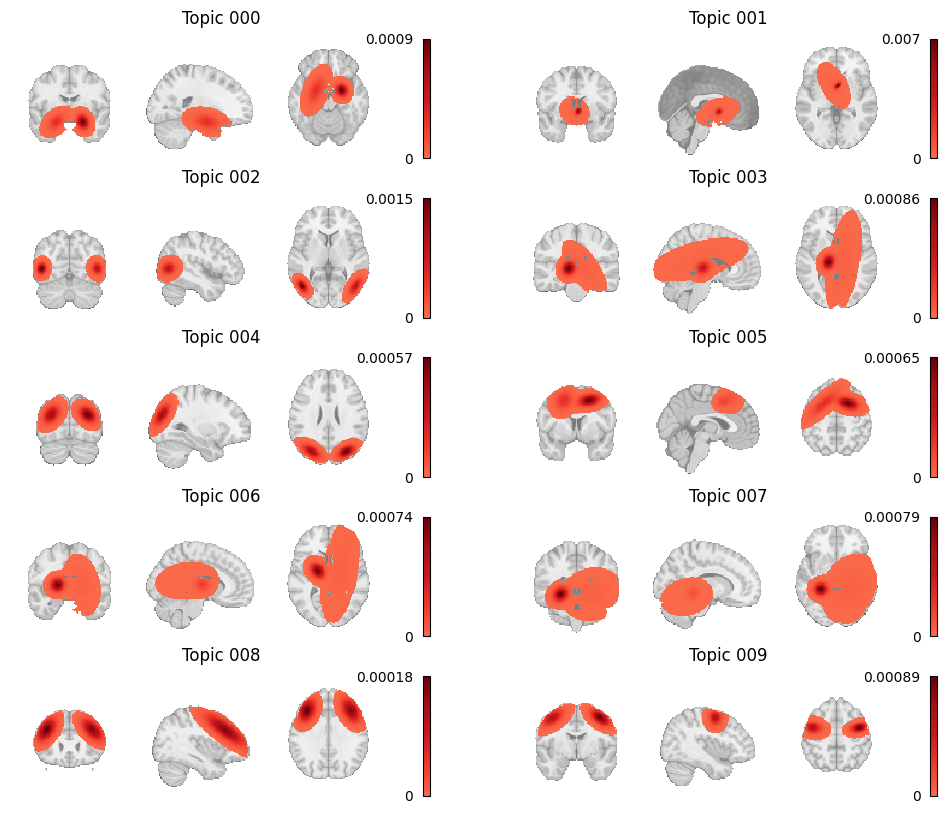

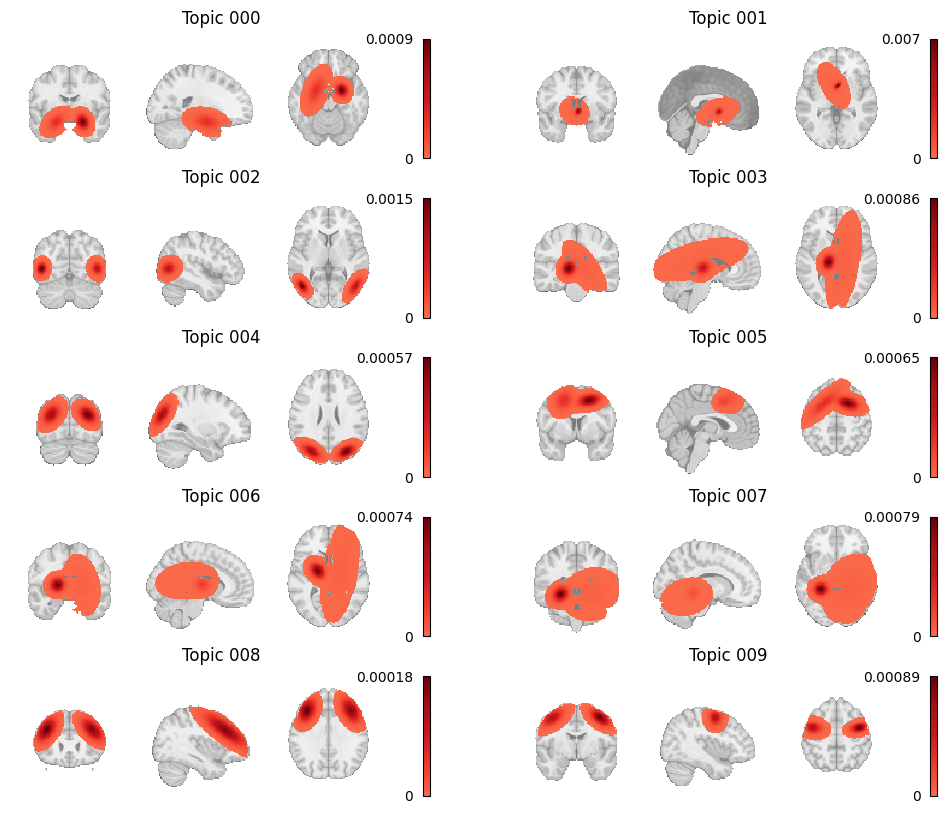

In [14]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 10))

topic_img_4d = neurosynth_dset_first_500.masker.inverse_transform(gclda_model.p_voxel_g_topic_.T)
# Plot first ten topics
topic_counter = 0
for i_row in range(5):
    for j_col in range(2):
        topic_img = image.index_img(topic_img_4d, index=topic_counter)
        display = plotting.plot_stat_map(
            topic_img,
            annotate=False,
            cmap="Reds",
            draw_cross=False,
            figure=fig,
            axes=axes[i_row, j_col],
        )
        axes[i_row, j_col].set_title(f"Topic {str(topic_counter).zfill(3)}")
        topic_counter += 1

        colorbar = display._cbar
        colorbar_ticks = colorbar.get_ticks()
        if colorbar_ticks[0] < 0:
            new_ticks = [colorbar_ticks[0], 0, colorbar_ticks[-1]]
        else:
            new_ticks = [colorbar_ticks[0], colorbar_ticks[-1]]
        colorbar.set_ticks(new_ticks, update_ticks=True)

glue("figure_gclda_topics", fig, display=False)

```{glue:figure} figure_gclda_topics
:name: figure_gclda_topics
:align: center

Topic weight maps for the first ten topics in the GCLDA model.
```

In [15]:
# Here we delete the recent variables for the sake of reducing memory usage
del gclda_model, temp_df, gclda_df, counts_df